In [2]:
# ===============================================
# STEP 0 — Imports, config, and speed knobs
# ===============================================
import warnings, time, numpy as np, pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, precision_recall_curve
)
import joblib

# ---- paths / label (EDIT as needed) ----
CSV_PATH     = r"C:\Users\Pily\Downloads\11_biz_merged_clean.csv"
TARGET_COL   = "avg_stars_2019"
POSITIVE_MIN = 4  # binarize: >= 4 stars => 1

# ---- speed knobs ----
CV_FOLDS             = 3
EN_N_ITER            = 12
RF_N_ITER            = 16
SUBSAMPLE_FOR_TUNING = None   # e.g. 25000 to tune on subset, then refit on full; or None
OHE_MIN_FREQ         = 20     # merge rare levels to reduce feature count
SEARCH_N_JOBS        = -1
VERBOSE              = 2

warnings.filterwarnings("ignore", message="Skipping features without any observed values")

In [3]:
# ===============================================
# STEP 1 — Load data
# ===============================================
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

Loaded: (36261, 61)


In [3]:
preprocessor

ColumnTransformer(force_int_remainder_cols='deprecated',
                  transformers=[('cont',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['latitude', 'longitude', 'review_count_log1p',
                                  'rl_word_mean', 'rl_share_short24',
                                  'total_weekly_hours', 'days_open',
                                  'weekend_hours', 'avg_daily_hours']),
                                ('ord',
                                 Pipeline(steps=[('encoder',
                                                  O...
                                ('onehot_already', 'passthrough',
                                 ['cat__Sandwiches',
                                  'cat__American (Traditional)', 'cat__Pizza',
                                  'cat__Fast Food', 'cat__Breakfast & Brunch',
                                  'cat__American (New)', 'cat__Burgers',
                                  'cat__Mexican', 'cat__Italian',
                                  'cat__Coffee & Tea', 'cat__Seafood',
                                  'cat__Chinese', 'cat__Salad',
                                  'cat__Chicken Wings', 'cat__Cafes',
                                  'cat__Delis', 'cat__Caterers',
                                  'cat__Specialty Food', 'cat__Bakeries',
                                  'cat__Desserts'])])

In [4]:
# ===============================================
# STEP 1B — Canonicalize dtypes (YOUR REQUESTED BLOCK)
#            + safe extras to avoid OHE blow-ups
# ===============================================
import numpy as np
import pandas as pd

# --- 1. Convert datetime columns ---
datetime_cols = ["first_review_2019", "last_review_2019"]
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Create numeric replacements for datetimes to use as features
# (days since epoch). We'll exclude the raw datetime columns from X later.
for col in datetime_cols:
    if col in df.columns:
        num_col = f"{col}_days"
        df[num_col] = (df[col].view("int64") / 86_400_000_000_000).astype("float64")  # ns -> days

# --- 2. Convert boolean-like columns ---
bool_cols = [
    "is_open", "attr_ByAppointmentOnly", "attr_BusinessAcceptsCreditCards",
    "attr_BikeParking", "attr_RestaurantsTakeOut", "attr_RestaurantsDelivery",
    "attr_Caters", "attr_WheelchairAccessible", "attr_HappyHour",
    "attr_OutdoorSeating", "attr_HasTV", "attr_RestaurantsReservations",
    "attr_DogsAllowed", "attr_GoodForKids", "attr_RestaurantsTableService",
    "attr_RestaurantsGoodForGroups", "attr_DriveThru", "has_hours_info"
]
bool_map = {
    "true": True, "false": False,
    "yes": True,  "no": False,
    "y": True,    "n": False,
    "t": True,    "f": False,
    "1": True,    "0": False,
    "none": np.nan, "nan": np.nan, "": np.nan
}
for col in bool_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str).str.strip().str.lower()
            .map(bool_map)
            .astype("boolean")
        )

# --- 3. Convert category columns to pandas 'category' dtype ---
category_cols = [
    "attr_RestaurantsPriceRange2", "attr_WiFi", "attr_Alcohol",
    "attr_RestaurantsAttire", "attr_NoiseLevel", "attr_Smoking"
]
for col in category_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# --- 4. Convert small integer indicator columns to int8 (memory) ---
int8_cols = [
    "cat__Sandwiches", "cat__American (Traditional)", "cat__Pizza",
    "cat__Fast Food", "cat__Breakfast & Brunch", "cat__American (New)",
    "cat__Burgers", "cat__Mexican", "cat__Italian", "cat__Coffee & Tea",
    "cat__Seafood", "cat__Chinese", "cat__Salad", "cat__Chicken Wings",
    "cat__Cafes", "cat__Delis", "cat__Caterers", "cat__Specialty Food",
    "cat__Bakeries", "cat__Desserts"
]
for col in int8_cols:
    if col in df.columns:
        # keep NA if any; if you know these are 0/1 without NA, you can fillna(0) before astype("int8")
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int8")

# --- 5. Convert others explicitly to float64 if present ---
float_cols = [
    "latitude", "longitude", "review_count", "review_count_log1p",
    "total_weekly_hours", "days_open", "weekend_hours", "avg_daily_hours",
    "avg_stars_2019", "rl_word_mean", "rl_share_short24"
]
for col in float_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("float64")

# --- 6. Optional: compress an example integer column ---
if "rev_count_2019" in df.columns:
    df["rev_count_2019"] = pd.to_numeric(df["rev_count_2019"], errors="coerce").fillna(0).astype("int64")

print("Dtypes normalized.")


C:\Users\Pily\AppData\Local\Temp\ipykernel_11600\2302231981.py:19: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[num_col] = (df[col].view("int64") / 86_400_000_000_000).astype("float64")  # ns -> days
C:\Users\Pily\AppData\Local\Temp\ipykernel_11600\2302231981.py:19: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[num_col] = (df[col].view("int64") / 86_400_000_000_000).astype("float64")  # ns -> days


Dtypes normalized.


In [5]:
# ===============================================
# STEP 2 — Target (binary) + feature matrix
# ===============================================
y = (pd.to_numeric(df[TARGET_COL], errors="coerce") >= POSITIVE_MIN).astype(int)

# Exclude raw datetime columns (we use *_days numeric features instead)
exclude = {
    "business_id", "city", "state", "review_text",
    "first_review_2019", "last_review_2019"  # raw datetime cols out
}
feature_cols = [c for c in df.columns if c not in set([TARGET_COL]) | exclude]
X = df[feature_cols].copy()

# Drop columns that are completely NaN
all_na_cols = [c for c in X.columns if X[c].notna().sum() == 0]
if all_na_cols:
    print(f"Dropping all-NaN columns: {all_na_cols}")
    X = X.drop(columns=all_na_cols)

print(f"X shape: {X.shape} | y+ rate: {float(y.mean()):.3f}")

Dropping all-NaN columns: ['attr_Smoking']
X shape: (36261, 56) | y+ rate: 0.386


In [6]:
# ===============================================
# STEP 3 — Train/Test split
# ===============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"y_train+ rate: {float(y_train.mean()):.3f} | y_test+ rate: {float(y_test.mean()):.3f}")

min_class = int(y_train.value_counts().min())
k = max(2, min(CV_FOLDS, min_class))
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
print(f"Using StratifiedKFold with n_splits={k}")

# Optional subsample for faster tuning
if SUBSAMPLE_FOR_TUNING and len(X_train) > SUBSAMPLE_FOR_TUNING:
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, train_size=SUBSAMPLE_FOR_TUNING, random_state=42)
    idx, _ = next(sss.split(X_train, y_train))
    X_tune, y_tune = X_train.iloc[idx], y_train.iloc[idx]
    print(f"Tuning on subsample: {X_tune.shape[0]} rows; will refit on full train.")
else:
    X_tune, y_tune = X_train, y_train

Train: (29008, 56) | Test: (7253, 56)
y_train+ rate: 0.386 | y_test+ rate: 0.385
Using StratifiedKFold with n_splits=3


In [7]:
# ===============================================
# STEP 4 — Preprocessor (imputers + safe cast + OHE with min_frequency)
# ===============================================
numeric_cols = X_train.select_dtypes(include=["number", "bool"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

def to_str_df(X_in):  # ensure uniform dtype for OneHotEncoder
    return X_in.astype(str)

num_pipe = SkPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])

cat_pipe = SkPipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="(missing)")),
    ("to_str", FunctionTransformer(to_str_df, validate=False)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=OHE_MIN_FREQ)),
])

pre = ColumnTransformer(
    transformers=[("num", num_pipe, numeric_cols), ("cat", cat_pipe, categorical_cols)],
    remainder="drop"
)
print(f"Preprocessor ready. Numeric: {len(numeric_cols)} | Categorical: {len(categorical_cols)}")

Preprocessor ready. Numeric: 51 | Categorical: 5


In [8]:
# ===============================================
# STEP 5 — Elastic Net (fast search) + STEP 5B refit
# ===============================================
pipe_en = SkPipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="elasticnet", solver="saga",
        max_iter=2000, tol=1e-3,  # looser for search
        class_weight="balanced", n_jobs=-1
    )),
])

param_dist_en = {
    "clf__C":        np.logspace(-2, 0, 5).tolist(),  # 0.01..1.0
    "clf__l1_ratio": [0.2, 0.4, 0.6, 0.8],
}

print("[EN] RandomizedSearch starting...")
t0 = time.time()
rs_en = RandomizedSearchCV(
    estimator=pipe_en,
    param_distributions=param_dist_en,
    n_iter=EN_N_ITER,
    scoring={"f1":"f1","roc_auc":"roc_auc"},
    refit="f1",
    cv=cv,
    n_jobs=SEARCH_N_JOBS,
    verbose=VERBOSE,
    random_state=42,
    error_score="raise"
)
rs_en.fit(X_tune, y_tune)
print(f"[EN] Done. Best params: {rs_en.best_params_} | Best CV F1: {rs_en.best_score_:.3f} | elapsed {time.time()-t0:.1f}s")

# Refit best on FULL train with tighter convergence
best_params_en = rs_en.best_params_
pipe_en.set_params(**best_params_en)
pipe_en.set_params(clf__max_iter=5000, clf__tol=1e-4)
pipe_en.fit(X_train, y_train)
print("[EN] Refit complete.")

[EN] RandomizedSearch starting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[EN] Done. Best params: {'clf__l1_ratio': 0.6, 'clf__C': 0.01} | Best CV F1: 0.648 | elapsed 50.6s
[EN] Refit complete.


In [9]:
# ===============================================
# STEP 6 — Evaluate Elastic Net (best-F1 threshold)
# ===============================================
def best_f1_threshold(y_true, probas):
    pr, rc, thr = precision_recall_curve(y_true, probas)
    f1s = 2 * (pr[:-1] * rc[:-1]) / (pr[:-1] + rc[:-1] + 1e-12)
    i = int(np.nanargmax(f1s))
    return float(thr[i])

proba_train_en = pipe_en.predict_proba(X_train)[:, 1]
proba_test_en  = pipe_en.predict_proba(X_test)[:, 1]
thr_en = best_f1_threshold(y_train, proba_train_en)

y_pred_en = (proba_test_en >= thr_en).astype(int)
acc_en = accuracy_score(y_test, y_pred_en)
f1_en  = f1_score(y_test, y_pred_en)
auc_en = roc_auc_score(y_test, proba_test_en)
cm_en  = confusion_matrix(y_test, y_pred_en)

print("\n=== ElasticNet-LogReg (test) ===")
print(f"Threshold: {thr_en:.3f}")
print(f"Accuracy:  {acc_en:.3f} | F1: {f1_en:.3f} | ROC-AUC: {auc_en:.3f}")
print("Confusion matrix (TN FP / FN TP):\n", cm_en)
print("\n" + classification_report(y_test, y_pred_en, digits=3))

en_results = {"model":"ElasticNet-LogReg","threshold":thr_en,"accuracy":acc_en,"f1":f1_en,"roc_auc":auc_en}




=== ElasticNet-LogReg (test) ===
Threshold: 0.472
Accuracy:  0.682 | F1: 0.650 | ROC-AUC: 0.773
Confusion matrix (TN FP / FN TP):
 [[2805 1652]
 [ 655 2141]]

              precision    recall  f1-score   support

           0      0.811     0.629     0.709      4457
           1      0.564     0.766     0.650      2796

    accuracy                          0.682      7253
   macro avg      0.688     0.698     0.679      7253
weighted avg      0.716     0.682     0.686      7253



In [10]:
# ===============================================
# STEP 7 — Random Forest (fast search) + STEP 7B refit
# ===============================================
pipe_rf = SkPipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=42,
        class_weight="balanced_subsample", n_jobs=-1
    )),
])

param_dist_rf = {
    "clf__n_estimators": [300, 400, 600, 800],
    "clf__max_depth": [None, 10, 20, 40],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None],
}

print("[RF] RandomizedSearch starting...")
t0 = time.time()
rs_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=RF_N_ITER,
    scoring={"f1":"f1","roc_auc":"roc_auc"},
    refit="f1",
    cv=cv,
    n_jobs=SEARCH_N_JOBS,
    verbose=VERBOSE,
    random_state=42,
    error_score="raise"
)
rs_rf.fit(X_tune, y_tune)
print(f"[RF] Done. Best params: {rs_rf.best_params_} | Best CV F1: {rs_rf.best_score_:.3f} | elapsed {time.time()-t0:.1f}s")

best_params_rf = rs_rf.best_params_
pipe_rf.set_params(**best_params_rf)
pipe_rf.fit(X_train, y_train)
print("[RF] Refit complete.")

[RF] RandomizedSearch starting...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[RF] Done. Best params: {'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': 40} | Best CV F1: 0.651 | elapsed 474.4s
[RF] Refit complete.


In [11]:
# ===============================================
# STEP 8 — Evaluate Random Forest (best-F1 threshold)
# ===============================================
proba_train_rf = pipe_rf.predict_proba(X_train)[:, 1]
proba_test_rf  = pipe_rf.predict_proba(X_test)[:, 1]
thr_rf = best_f1_threshold(y_train, proba_train_rf)

y_pred_rf = (proba_test_rf >= thr_rf).astype(int)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, proba_test_rf)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

print("\n=== RandomForest (test) ===")
print(f"Threshold: {thr_rf:.3f}")
print(f"Accuracy:  {acc_rf:.3f} | F1: {f1_rf:.3f} | ROC-AUC: {auc_rf:.3f}")
print("Confusion matrix (TN FP / FN TP):\n", cm_rf)
print("\n" + classification_report(y_test, y_pred_rf, digits=3))

rf_results = {"model":"RandomForest","threshold":thr_rf,"accuracy":acc_rf,"f1":f1_rf,"roc_auc":auc_rf}



=== RandomForest (test) ===
Threshold: 0.505
Accuracy:  0.723 | F1: 0.652 | ROC-AUC: 0.798
Confusion matrix (TN FP / FN TP):
 [[3370 1087]
 [ 919 1877]]

              precision    recall  f1-score   support

           0      0.786     0.756     0.771      4457
           1      0.633     0.671     0.652      2796

    accuracy                          0.723      7253
   macro avg      0.709     0.714     0.711      7253
weighted avg      0.727     0.723     0.725      7253



In [12]:
# ===============================================
# STEP 9 — Compare & save
# ===============================================
summary = pd.DataFrame([en_results, rf_results]).set_index("model")[["threshold","accuracy","f1","roc_auc"]]
print("\nModel comparison:")
print(summary)

joblib.dump(pipe_en, "best_elasticnet_pipeline.joblib")
joblib.dump(pipe_rf, "best_randomforest_pipeline.joblib")
summary.to_csv("model_summary.csv", index=True)
print("Saved: best_elasticnet_pipeline.joblib, best_randomforest_pipeline.joblib, model_summary.csv")


Model comparison:
                   threshold  accuracy        f1   roc_auc
model                                                     
ElasticNet-LogReg   0.471591  0.681925  0.649871  0.773429
RandomForest        0.505171  0.723425  0.651736  0.798250
Saved: best_elasticnet_pipeline.joblib, best_randomforest_pipeline.joblib, model_summary.csv


In [13]:
# --- Step 9A: Collect metrics & probabilities for plotting ---

import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix
)

# Pull metrics from your earlier dicts; if missing, recompute
def ensure_results(pipe, name):
    proba_test = pipe.predict_proba(X_test)[:, 1]
    # default 0.5 threshold (for confusion matrix plots)
    y_pred_05 = (proba_test >= 0.5).astype(int)
    auc = roc_auc_score(y_test, proba_test)
    ap  = average_precision_score(y_test, proba_test)
    return {"name": name, "proba": proba_test, "y_pred_05": y_pred_05, "auc": auc, "ap": ap}

res_en = ensure_results(pipe_en, "ElasticNet-LogReg")
res_rf = ensure_results(pipe_rf, "RandomForest")

# Use your computed test metrics (en_results/rf_results) if they exist; otherwise compute quick ones
def metric_or(df_dict, fallback_auc):
    acc = df_dict.get("accuracy", None)
    f1  = df_dict.get("f1", None)
    auc = df_dict.get("roc_auc", fallback_auc)
    return acc, f1, auc

acc_en, f1_en, auc_en = metric_or(locals().get("en_results", {}), res_en["auc"])
acc_rf, f1_rf, auc_rf = metric_or(locals().get("rf_results", {}), res_rf["auc"])

summary_df = pd.DataFrame([
    {"model":"ElasticNet-LogReg","accuracy":acc_en,"f1":f1_en,"roc_auc":auc_en},
    {"model":"RandomForest","accuracy":acc_rf,"f1":f1_rf,"roc_auc":auc_rf},
]).set_index("model")

summary_df


,accuracy,f1,roc_auc
model,,,
ElasticNet-LogReg,0.681925,0.649871,0.773429
RandomForest,0.723425,0.651736,0.798250


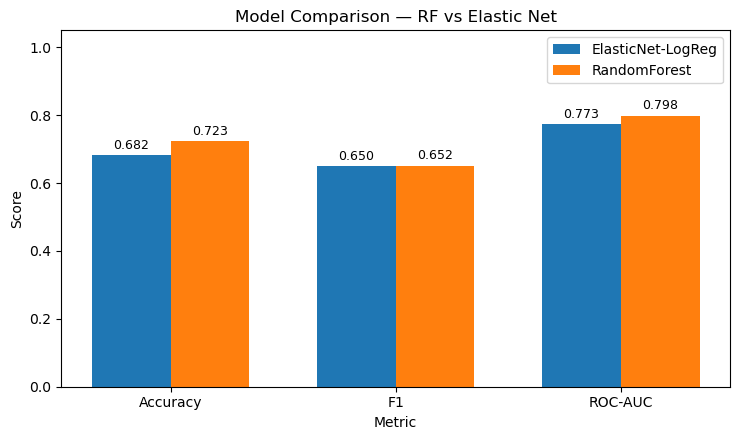

In [14]:
# --- Step 9B: Bar chart comparison (Accuracy, F1, ROC-AUC) ---

import matplotlib.pyplot as plt
metrics = ["accuracy","f1","roc_auc"]

fig = plt.figure(figsize=(7.5, 4.5))
x = np.arange(len(metrics))
width = 0.35

vals_en = summary_df.loc["ElasticNet-LogReg", metrics].values.astype(float)
vals_rf = summary_df.loc["RandomForest", metrics].values.astype(float)

plt.bar(x - width/2, vals_en, width, label="ElasticNet-LogReg")
plt.bar(x + width/2, vals_rf, width, label="RandomForest")

for i, v in enumerate(vals_en):
    plt.text(x[i]-width/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(vals_rf):
    plt.text(x[i]+width/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, ["Accuracy","F1","ROC-AUC"])
plt.ylim(0, 1.05)
plt.title("Model Comparison — RF vs Elastic Net")
plt.legend()
plt.xlabel("Metric")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


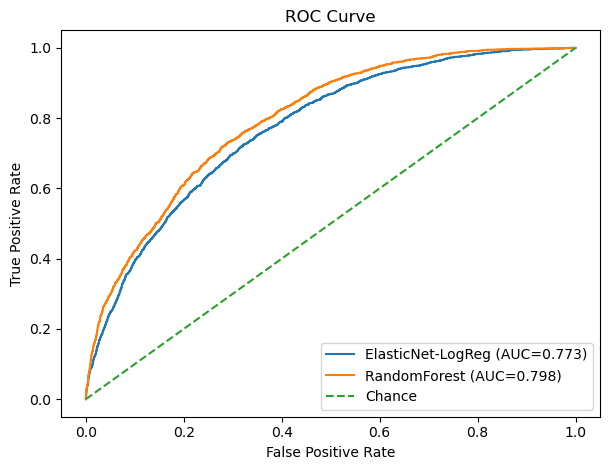

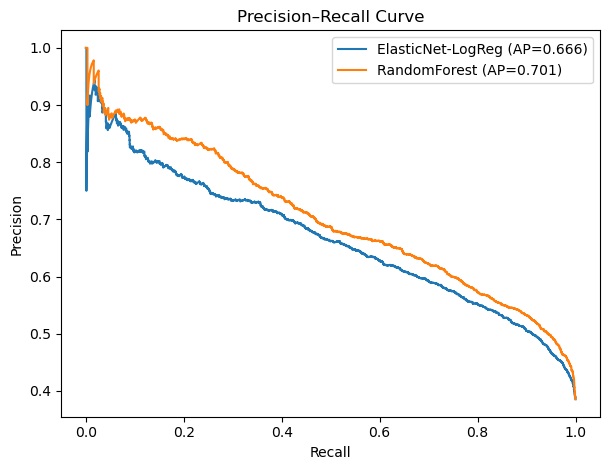

In [15]:
# --- Step 9C: ROC and Precision–Recall curves ---

from sklearn.metrics import roc_curve, precision_recall_curve

# ROC
fig = plt.figure(figsize=(6.2,4.8))
for name, proba in [("ElasticNet-LogReg", res_en["proba"]), ("RandomForest", res_rf["proba"])]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall
fig = plt.figure(figsize=(6.2,4.8))
for name, proba in [("ElasticNet-LogReg", res_en["proba"]), ("RandomForest", res_rf["proba"])]:
    p, r, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


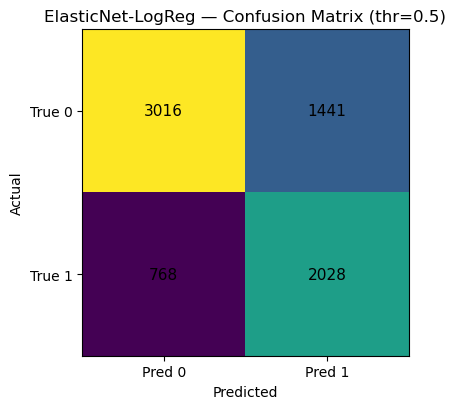

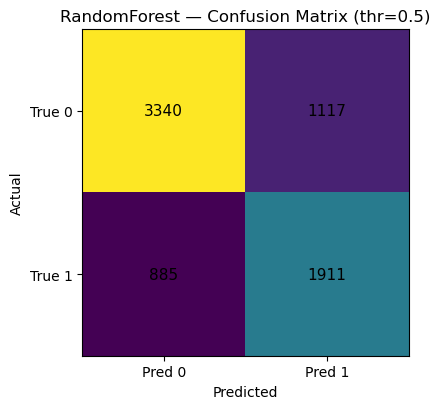

In [16]:
# --- Step 9D: Confusion matrices (threshold = 0.5) ---

from matplotlib import pyplot as plt

def plot_cm(cm, title):
    fig = plt.figure(figsize=(4.6,4.2))
    plt.imshow(cm, interpolation="nearest")
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, f"{v}", ha="center", va="center", fontsize=11)
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["True 0","True 1"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

cm_en = confusion_matrix(y_test, res_en["y_pred_05"])
cm_rf = confusion_matrix(y_test, res_rf["y_pred_05"])

plot_cm(cm_en, "ElasticNet-LogReg — Confusion Matrix (thr=0.5)")
plot_cm(cm_rf, "RandomForest — Confusion Matrix (thr=0.5)")
